# First Analysis of IRIS data for M project

Data in scratch partition /local/scratch2/rowan/

 - ~~generate optical thickness map~~
 - ~~doppler shift map~~
 - ~~total intensity map~~

to determine line centre can try and use quantile analysis i.e. wavelength at 50% of total integrated intensity

compare to off-limb reference wavelength for Doppler

Notes 21/11/20
1. ~~get the h and k line profiles for each pixel~~
2. ~~find the integrated line intensity (area under line) for each~~
3. ~~h/k gives the line ratio - this is the optical thickness~~
4. ~~find the line centres using quantile analysis method (or other as I see fit)~~
5. ~~calculate a reference wavelength by averaging a patch of off-limb sky~~
6. ~~difference between the two and translate into a velocity using maffs~~
7. ~~calculate total intensity under entire Mg II h and k profile area as a function of pixel and plot~~

Notes 26/11/20
1. ~~calibrate intensity from DNs to Flux in ergs~~
2. ~~change from summing to real integration inc wavelength increments etc.~~ Using Simpson's rule where dx=CDELT from header
3. ~~off-limb calculation~~
    * ~~cut out section of off-limb~~
    * ~~sum profiles to get better SNR and find line centre~~
    * troubleshoot this?
4. ~~change pixels to arcseconds in plots~~
5. ~~orientate the images correctly~~
6. ~~apply their weirdo cmap~~

Notes 03/12/20
1. Mask the background sky like in Zhang paper?
2. ~~Troubleshoot Doppler shift~~
3. ~~Radiometric calibration~~
4. ~~Find correct raster from DATE-OBS in header~~ - raster 13 is 15:10 to 15:27 UT
5. ~~change aspect ratio to CDELT2/CDELT3 or whatever~~
6. ~~try summing the noise over all rasters for off-limb profile~~
8. ~~look at temporal evolution, compare distinct phases and start/middle/end for example~~
9. ~~start looking at the line profiles, spread and evolution~~
10. ~~low values of k/h in prominence could be result of doppler dimming? see Liu paper~~
11. h/k ratio could give idea about temperature? see Levens and Labrosse
12. think of ways to constrain slab thickness, pressure, temperature from observations (line profiles)

Notes 12/01/21
- Slightly behind original project plan, finish data analysis needs 1 or 2 more weeks
1. ~~Top priority is radiometric calibration~~
2. Constraining slab properties, how did Zhang approach this? 
3. Looking more at temporal evolution etc.
4. ~~Projection onto correct axes for temporal plot~~


Notes 14/01/21
1. check all against Zhang
2. share code with Nic and Aaron for Doppler part
3. remove background noise to get off-limb profile and narrow spectral range for both
4. upload technical essay to Teams
5. Notes on 13th raster wavelength/time plot, add context and fix axes etc etc.
6. Finish up with observations, is there AIA data I can quickly check?
7. Look at large scale temporal evolution
8. What is the pixel profile envolution representing, how does it relate to large scale, why are there such large changes?

## Read in IRIS raster files for Zhang event
28th May 2014, FE, 

In [1]:
%matplotlib inline
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
import matplotlib.cm as mcm
import matplotlib.colors as mc
from scipy.integrate import simps

In [2]:
mgIIk = 279.6351
mgIIh = 280.27056
h = 6.62607015e-34  #J.s
c = 299792458  #m/s

In [3]:
rasters = []
[rasters.append(fits.open('/local/scratch2/rowan/masters/Zhang/iris_l2_20140528_112458_3820111493_raster_t000_r000' + "%02d" % i +'.fits', 
                   memap=True, do_not_scale_image_data=True)) for i in range(16)]

data = rasters[13][8].data  # raster 13 is the one pictured in Zhang et al. (2019)
hd = rasters[0][0].header
hd1 = rasters[0][1].header
wcs = WCS(hd)

In [4]:
mcm.register_cmap(name='bgry', cmap=mc.LinearSegmentedColormap.from_list(name='bgry', colors=['midnightblue', 'green', 'red', 'yellow']))
plt.rcParams['figure.figsize'] = [6,10]
plt.rcParams['image.aspect'] = hd1['CDELT2']/hd1['CDELT3']
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

print('Window. Name      : wave start - wave end\n')
for i in range(hd['NWIN']):
    win = str(i + 1)
    print('{0}. {1:15}: {2:.2f} - {3:.2f} Å'
          ''.format(win, hd['TDESC' + win], hd['TWMIN' + win], hd['TWMAX' + win]))

These are all the wavelengths - i'm into [8]

raster[8].data.shape # (number of raster positions, y coordinate, wavelength)

In [216]:
wcs = WCS(rasters[0][8].header)
m_to_nm = 1e9
nwave = data.shape[2]
wavelength = wcs.all_pix2world(np.arange(nwave), [0.], [0.], 0)[0] * m_to_nm
wavelengths = np.round(wavelength,3)

# use the WCS header information to convert from pixels to wavelength scale

IndexError: list index out of range

## Raster Image

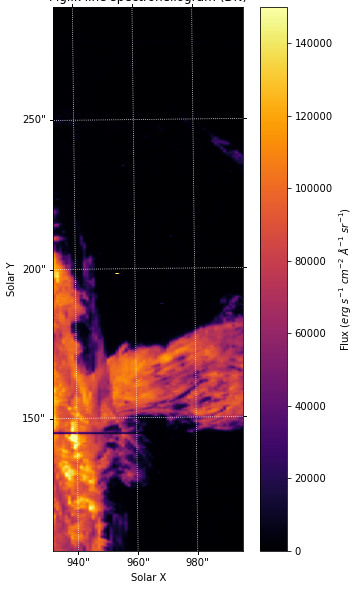

In [165]:
mg_index = np.argmin(np.abs(wavelength - mgIIk))


figure = plt.figure()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow(rasters[11][3].data[..., mg_index].T, vmin=0, vmax=150000)
plt.colorbar(im, label=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.title('MgIIk line spectroheliogram (DN)')
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")
plt.grid(color='w', ls=':')

# be clear about what part of line profile I am plotting here

## Radiometric Calibration

Used radcal.py with help from Aaron, got it sorted, flux now in r'$erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$'

## Line profiles

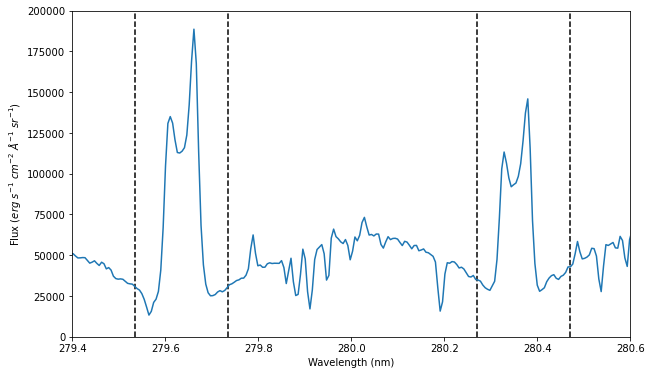

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(wavelength, data[0, 150])
plt.xlabel("Wavelength (nm)")
plt.ylabel(r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')

plt.xlim([279.4, 280.6])
plt.ylim([0, 200000])

plt.vlines([mgIIk-0.1, mgIIk+0.1, mgIIh, mgIIh+0.2], 0, 200000, colors='k', linestyles='dashed')

Okay so the line profile for any pixel can be given by wavelength vs raster[8].data[x, y], here in dotted lines I'm showing the places I'm going to use as boundaries to integrate the line profiles.

## Integrated h and k lines as a function of pixel

In [53]:
bounds = np.round((np.array([mgIIk-0.1, mgIIk+0.1, mgIIh, mgIIh+0.2])-wavelength[0])/1e9/5.09199984372e-12).astype(int)
lenx = len(data[:,0])
leny = len(data[0,:])

bounds, lenx, leny

(array([ 46,  86, 191, 230]), 64, 548)

In [55]:
integrated_k = np.zeros([lenx, leny])
integrated_h = np.zeros([lenx, leny])
profile = np.zeros([lenx, leny])

for i in range(lenx):
    for j in range(leny):
        profile = data[i, j]
        integrated_k[i, j] = simps(profile[bounds[0]:bounds[1]], dx=hd1['CDELT1'])
        integrated_h[i, j] = simps(profile[bounds[2]:bounds[3]], dx=hd1['CDELT1'])

In [56]:
integrated_k[1,0]

65711.93547107109

(50.0, 250.0)

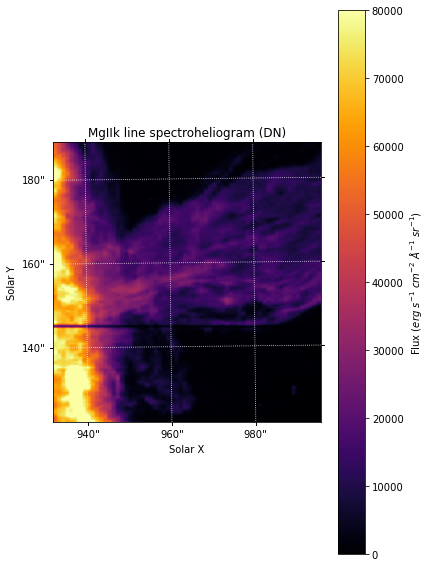

In [62]:
figure = plt.figure()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow(integrated_k.T, vmin=0, vmax=80000)
plt.colorbar(im, label=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.title('MgIIk line spectroheliogram (DN)')
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")
plt.grid(color='w', ls=':')
plt.ylim(50, 250)

(50.0, 250.0)

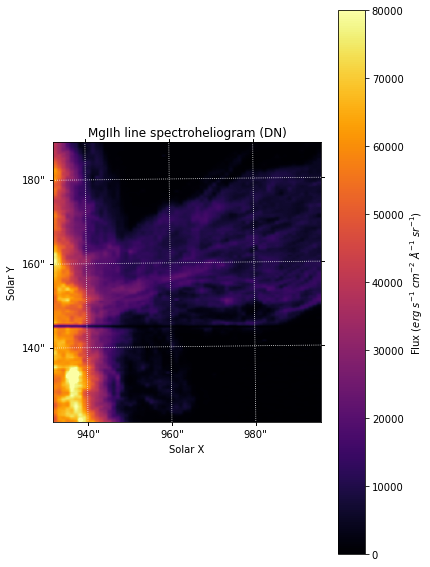

In [61]:
figure = plt.figure()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow(integrated_h.T, vmin=0, vmax=80000)
plt.colorbar(im, label=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.title('MgIIh line spectroheliogram (DN)')
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")
plt.grid(color='w', ls=':')
plt.ylim(50, 250)

## H to K line ratio

(50.0, 500.0)

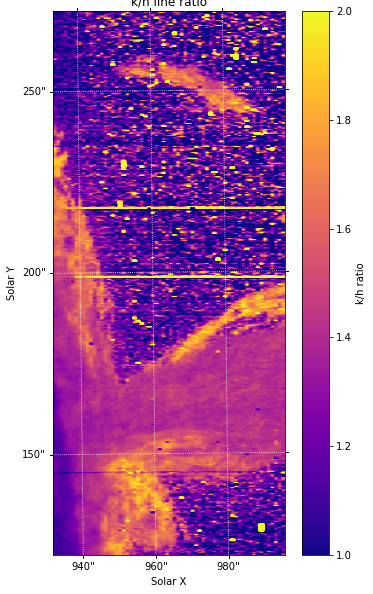

In [65]:
figure = plt.figure()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow((integrated_k/integrated_h).T, vmin=1, vmax=2, cmap='plasma')
plt.colorbar(im, label='k/h ratio')
plt.title('k/h line ratio')
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")
plt.grid(color='w', ls=':')
plt.ylim(50, 500)

### Notes on Mg II k/h ratio

Liu et al. (2015)

- Showed a strong (>5sigma) linear relationship between k/h ratio and Doppler dimming effect
- 1.17 low ratio in fallback plasma where expect to approach ~2 (optically thin regime)

Zhang et al. (2019)

- k/h ratio larger than 1.35 in the prominence and around 1.4 in main body
- We also derived k/h ratios up to 1.7 to 2.0 in regions close to the edges, where Doppler redshifts are relatively larger. This is perhaps an indication that the medium is not so thick and has a higher (relative) collisional contribution resulting from a higher temperature close to the edges.

## Find line centre at 0.5 of total summed intensity

i.e. need to integrate from one side to another until I reach 0.5 x integrated_X


    set up a loop for wavelength i:
        total intensity = total intensity + intensity of i
        if intensity <= 0.5 x integrated_X:
            continue
        else print(line centre is at i)
        
Then doppler effect v/c = dlambda/lambda0
or v = c * dlambda / lambda0

In [67]:
centre_h = np.zeros([lenx, leny])  # set up matrices of dimensions same as image
centre_k = np.zeros([lenx, leny])

for i in range(lenx):
    for j in range(leny): # for each pixel

        totalh = 0
        for k in range(bounds[0], bounds[1]):  # for increment in the h line range 
            if totalh < 0.5*integrated_h[i, j]:  # when the total intensity reaches half the integrated intensity from before
                totalh += data[0,0][k] * hd1['CDELT1'] # increase the total integrated intensity 
                                                                                      # of the line by adding the intensity at 
                                                                                      # that point
                continue
            else:
                centre_h[i, j] = wavelength[k]  # save the corresponding wavelength to the new matrix
                break

        totalk = 0
        for l in range(bounds[2], bounds[3]):  # repeat for the k line
            if totalk < 0.5*integrated_k[i, j]:
                totalk += data[0,0][l] * hd1['CDELT1']
                continue
            else:
                centre_k[i, j] = wavelength[l]
                break

## Create Doppler Map

Calculate reference wavelengths and then the line centres of each pixel

### Sum noise over rasters and find line centres to get reference wavelengths

In [69]:
summed_profile = 0
for k in range(10):  # for all rasters
    for i in range(20, 64):  
        for j in range(400, 500):  # for pixel in our range
            profile = rasters[k][3].data[i, j] # calculate the profile
            summed_profile += profile  # add it to the summed noise profile
summed_profile = summed_profile/len(summed_profile)

Text(0.5, 0, 'Wavelength (nm)')

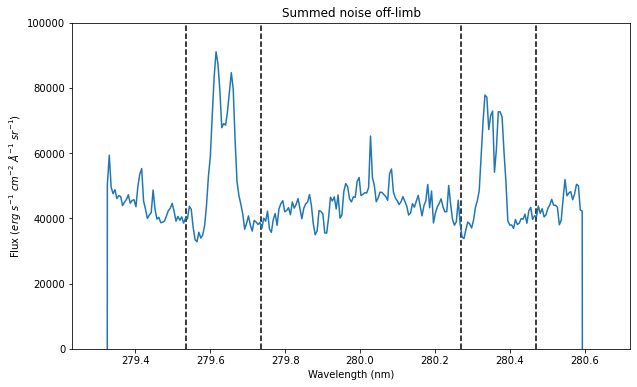

In [76]:
plt.figure(figsize=(10,6))
plt.plot(wavelength, summed_profile)
plt.ylim(0, 100000)
plt.title('Summed noise off-limb')
plt.vlines([mgIIk-0.1, mgIIk+0.1, mgIIh, mgIIh+0.2], 0, 100000, colors='k', linestyles='dashed')
plt.ylabel(r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.xlabel('Wavelength (nm)')

# remove background

In [77]:
limb_integ_h = simps(summed_profile[bounds[0]:bounds[1]], dx=hd1['CDELT1'])
limb_integ_k = simps(summed_profile[bounds[2]:bounds[3]], dx=hd1['CDELT1'])

In [78]:
totalh = 0
for h in range(bounds[0], bounds[1]):  # for increment in the h line range
    totalh += summed_profile[h] * hd1['CDELT1'] # increase the total integrated intensity of the line by adding the 
                                                # intensity at that point
    if totalh <= 0.5*limb_integ_h:  # when the total intensity reaches half the integrated intensity from before
        continue
    else:
        limb_centre_h = wavelength[h]  # save the corresponding wavelength to the new matrix
        break
totalk = 0
for k in range(bounds[2], bounds[3]):  # repeat for the k line
    totalk += summed_profile[k] * hd1['CDELT1']
    if totalk <= 0.5*limb_integ_k:
        continue
    else:
        limb_centre_k = wavelength[k]
        break

In [79]:
limb_centre_h, limb_centre_k

(279.6306896568418, 280.36393763433745)

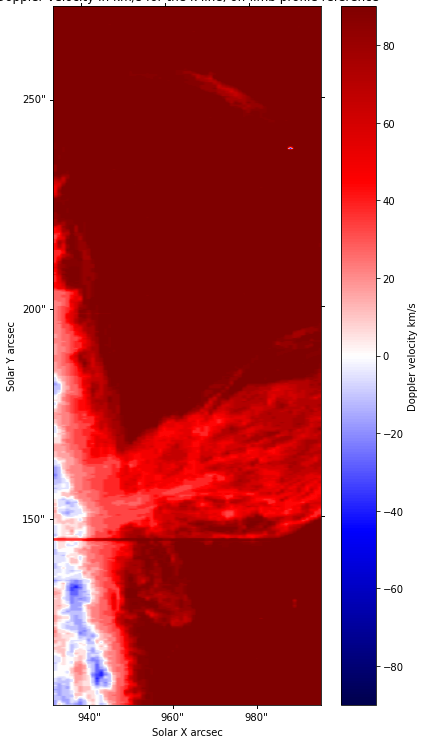

In [152]:
doppler_velocity = 3e8 * (limb_centre_k - centre_k) / 279.535 / 1000

figure = plt.figure()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow(doppler_velocity.T, vmin=-90, vmax=90, cmap='seismic') 
plt.colorbar(im, label='Doppler velocity km/s')
plt.title('Doppler velocity in km/s for the k line, off-limb profile reference')
plt.ylim(0, 500)
plt.ylabel('Solar Y arcsec')
plt.xlabel('Solar X arcsec')
figure.tight_layout()

## Types of line profile seen

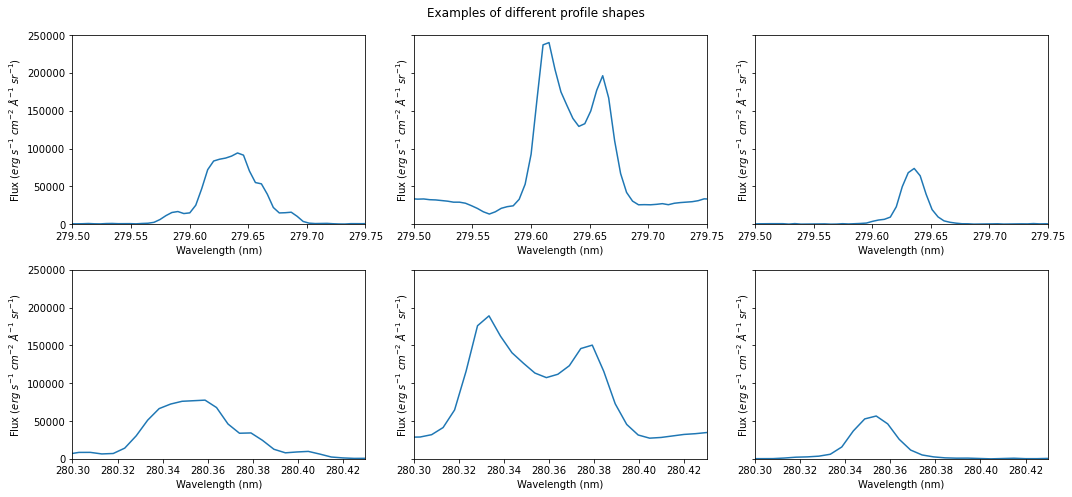

In [219]:
fig, axs = plt.subplots(2, 3, figsize=(15,7), sharey=True)

axs[0,0].plot(wavelength, data[15, 150])
axs[0,1].plot(wavelength, data[0, 160])
axs[0,2].plot(wavelength, data[50, 200])
axs[1,0].plot(wavelength, data[15, 150])
axs[1,1].plot(wavelength, data[0, 160])
axs[1,2].plot(wavelength, data[50, 200])

plt.setp(axs[0,:], xlabel='Wavelength (nm)', xlim=[279.5, 279.75], ylabel=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)', ylim=[0, 250000]);
plt.setp(axs[1,:], xlabel="Wavelength (nm)", xlim=[280.3, 280.43], ylabel=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)', ylim=[0, 250000]);

fig.suptitle('Examples of different profile shapes')
fig.tight_layout()

## Evolution of these pixels in time (top: raster 0, middle: raster 6, bottom: raster 15)

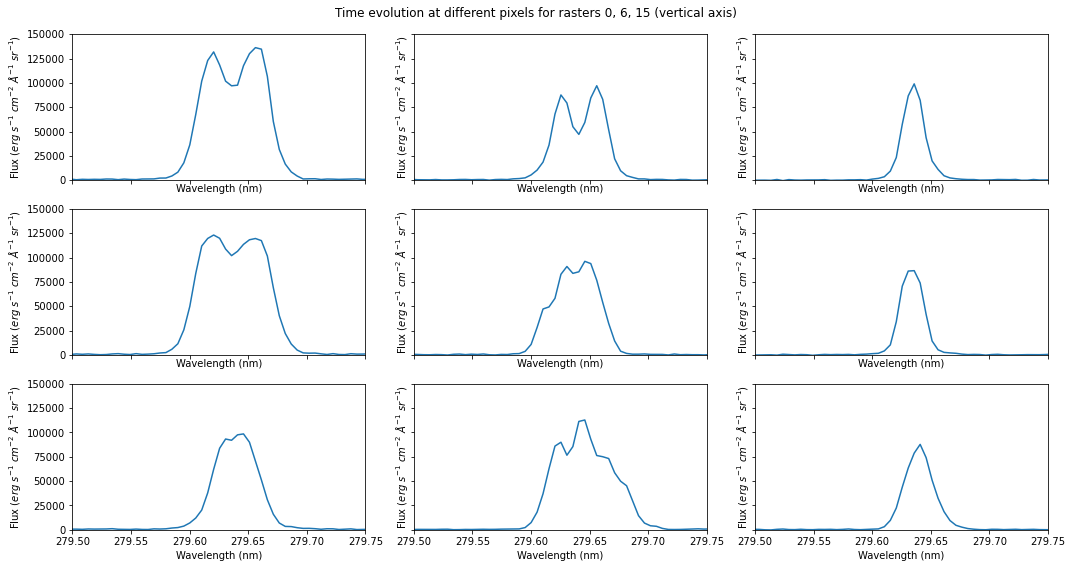

In [220]:
fig, axs = plt.subplots(3, 3, figsize=(15,8), sharex=True, sharey=True)

axs[0,0].plot(wavelength, rasters[0][3].data[5, 190]);
axs[0,1].plot(wavelength, rasters[0][3].data[15, 150]);
axs[0,2].plot(wavelength, rasters[0][3].data[50, 200]);

axs[1,0].plot(wavelength, rasters[6][3].data[5, 190]);
axs[1,1].plot(wavelength, rasters[6][3].data[15, 150]);
axs[1,2].plot(wavelength, rasters[6][3].data[50, 200]);

axs[2,0].plot(wavelength, rasters[15][3].data[5, 190]);
axs[2,1].plot(wavelength, rasters[15][3].data[15, 150]);
axs[2,2].plot(wavelength, rasters[15][3].data[50, 200]);


plt.setp(axs, xlim=[279.5, 279.75], ylabel=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)', ylim=[-5, 150000], xlabel='Wavelength (nm)');

fig.suptitle('Time evolution at different pixels for rasters 0, 6, 15 (vertical axis)')
fig.tight_layout()

## Location of these pixels on raster img

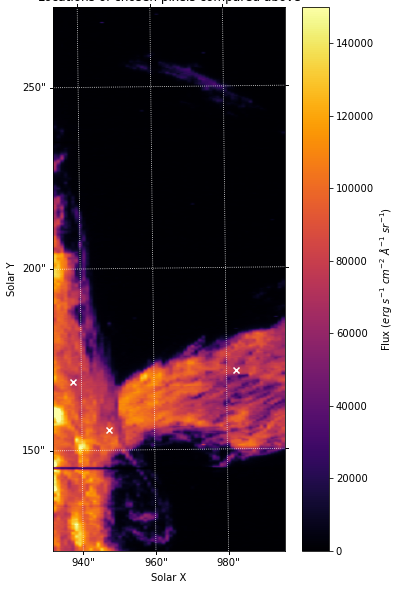

In [222]:
figure = plt.figure()
ax = plt.subplot()
ax = plt.subplot(projection=wcs.dropaxis(0), slices=('y', 'x'))
im = plt.imshow(data[..., mg_index].T , vmin=0, vmax=150000)
plt.scatter([5, 15, 50], [190, 150, 200], c='white', marker='x')
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")
plt.ylim(50, 500)
plt.grid(color='w', ls=':')
plt.colorbar(im, label=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.title('Locations of chosen pixels compared above')
plt.show()

## Time domain raster scan vs step

<ipython-input-224-4664ee25b4a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wavelengths)
<ipython-input-224-4664ee25b4a6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(times)


Text(0, 0.5, 'Time / Raster Scan')

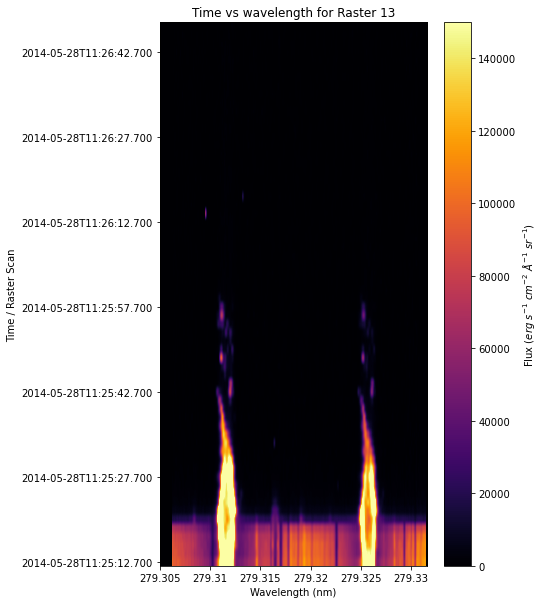

In [224]:
time_diff = hd['EXPTIME']
times = [np.datetime64(hd['DATE_OBS']) + time_diff * np.timedelta64(i, 's') for i in range(len(data[0,...]))]
wavelengths = np.round(wavelength,3)

fig, ax = plt.subplots(1,1)
img = ax.imshow(data[:, 100, :], vmin=0, vmax=100000, aspect='auto')

ax.set_xticklabels(wavelengths)
ax.set_yticklabels(times)

fig.colorbar(im, label=r'Flux ($erg$ $s^{−1}$ $cm^{−2}$ $\AA^{-1}$ $sr^{−1}$)')
plt.title('Time vs wavelength for Raster 13')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Time / Raster Scan")

# zoom in on line
# correct wavel axis
# context

## Temperature Estimate

- brightness temperature?
- thermal broadening?
- Zhang not much help
- read Liu sections
- Heinzel et al, central reversal at temperatures over X for pressure Y

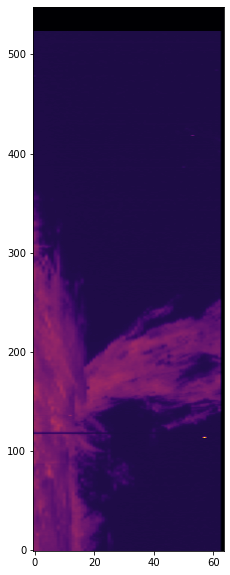

In [111]:
import matplotlib.animation as animation

fig = plt.figure()

ims = []
for i in range(len(rasters)):
    ims.append([plt.imshow(rasters[i][3].data[..., mg_index].T)])

ani = animation.ArtistAnimation(fig, ims, 500, blit=True, repeat_delay=0)

from matplotlib.animation import ImageMagickFileWriter
FFwriter=animation.FFMpegWriter(fps=5)
ani.save('rasters.mp4', writer=FFwriter)